## Preparation

Import all necessary packages

In [ ]:
import os

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series

import matplotlib.dates as mdates
%matplotlib inline

This auxuliary function returns a dataframe containing publication year, month and filepath of all documents

In [2]:
def get_file_paths(CLEAN_DATA_DIR: str) -> pd.DataFrame:
    """
    Given a the clean_data directory, it returns dataframe containing year, month and filepath.
    param CLEAN_DATA_DIR: path to clean_data folder
    return: dataframe with columns year, month, path
    """
    documents = pd.DataFrame(
        [
            {
                "year": int(year),
                "month": int(month),
                "path": os.path.join(CLEAN_DATA_DIR, year, month, file),
            }
            for year in os.listdir(CLEAN_DATA_DIR)
            for month in os.listdir(os.path.join(CLEAN_DATA_DIR, year))
            for file in os.listdir(os.path.join(CLEAN_DATA_DIR, year, month))
            if os.path.isfile(os.path.join(CLEAN_DATA_DIR, year, month, file))
        ]
    )
    return documents

This function will be used for computing mean tf-idf score for each month in the tf-idf matrix.

In [3]:
def sparse_group_by_mean(
        sparse_matrix: csr_matrix, group_by_factor: pd.DataFrame
) -> csr_matrix:
    """
    Equivalent of sparse_matrix.groupby(groupby_factor.columns).mean() for sparse matrices.
    sparse_matrix and groupby_factor must have the same row numbers!
    param sparse_matrix: sparse matrix to be grouped (by rows)
    param group_by_factor: must be a data frame
    return:
    """
    if group_by_factor.shape[0] != sparse_matrix.shape[0]:
        raise ValueError("dimension mismatch")
    auxiliary = group_by_factor.copy().reset_index(drop=True)
    auxiliary["row"] = (
        auxiliary.groupby(group_by_factor.columns.to_list())
            .ngroup()
            .reset_index(drop=True)
    )
    auxiliary['value'] = (
        auxiliary.groupby(group_by_factor.columns.to_list())
            .transform(lambda x: 1 / len(x))
    )
    auxiliary["col"] = auxiliary.index

    # some algebra is done here, each row represents one group,
    # and each column represents each row
    # in each row there are 1/n in columns which belong to the group represented by the row
    # n = length of the group
    # grouping_matrix is stored as sparse for efficiency
    grouping_matrix = csr_matrix(
        (auxiliary["value"], (auxiliary["row"], auxiliary["col"]))
    )
    return grouping_matrix @ sparse_matrix

## Time series clustering

In [4]:
CLEAN_DATA_DIR = os.path.join("..", "clean_data")
N_words = 1000
documents = get_file_paths(CLEAN_DATA_DIR).sort_values(["year", "month"])

Calculating tfidf matrix for all words and documents

In [5]:
model_tfidf = TfidfVectorizer(input="filename", use_idf=True)
tfidf_matrix = model_tfidf.fit_transform(documents.path)
vocabulary = pd.DataFrame(
    {
        "word": np.array(model_tfidf.get_feature_names()),
        "relevance": np.array(tfidf_matrix.mean(0)).reshape(-1),
    }
)

Selecting the most relevant columns (words) from the tf-idf matrix

In [6]:
# indices of words with highest relevance
indices = np.argsort(vocabulary["relevance"])[::-1][:N_words]
# taking subset of most relevant words from tfidf matrix and vocabulary
tfidf_matrix = tfidf_matrix[:, indices]
vocabulary = vocabulary.iloc[indices]

Computing mean tfidf score per word, grouping by publication month.

In [7]:
tfidf_avg_monthly = sparse_group_by_mean(tfidf_matrix, documents[["year", "month"]])
# names of all years and months without duplicates
months_grouped = documents[["year", "month"]].drop_duplicates()
# making a DataFrame to store words in the column names and dates in indexes.
tfidf_monthly_dataframe = pd.DataFrame(
    tfidf_avg_monthly.toarray(),
    columns=vocabulary["word"],
    index=pd.to_datetime(
        {"year": months_grouped.year, "month": months_grouped.month, "day": 1}
    ),
)

Converting data to time series and clustering.

In [8]:
# time series - each row(word) is one time serie
# each time series is an array of 72 months.
time_series = to_time_series(tfidf_monthly_dataframe.values.transpose())
N_clusters = 7
model = TimeSeriesKMeans(N_clusters)
vocabulary["cluster"] = model.fit_predict(time_series)

Assigning colors to clusters.

In [9]:
# mapping cluster numbers to colors
colors = pd.DataFrame(pl.cm.jet(np.linspace(0, 1, N_clusters)))
vocabulary.sort_values(["cluster", "relevance"], inplace=True, ascending=False)
# getting the most relevant words for each topic
topics = (
    vocabulary[["cluster", "word"]]
        .groupby("cluster")
        .agg(
        {
            "word": lambda words: ", ".join(words[:15]),
        }
    )
).reset_index().rename({'Index': 'cluster'})

Computing clusters centers.

In [10]:
clusters_centers = pd.DataFrame(
    model.cluster_centers_.reshape((N_clusters, -1)).transpose(),
    columns=topics["word"],
    index=pd.to_datetime(
        {"year": months_grouped.year, "month": months_grouped.month, "day": 1}
    ),
)

Cleaning up.

In [11]:
# rejecting technical results
topics=topics[topics.word.apply(lambda col: (('pdf' not in col)&('arxiv' not in col)))]
# rejecting results from 2020
tfidf_monthly_dataframe = tfidf_monthly_dataframe[tfidf_monthly_dataframe.index < '2020']
clusters_centers = clusters_centers.loc[clusters_centers.index < '2020']

Plotting the results.

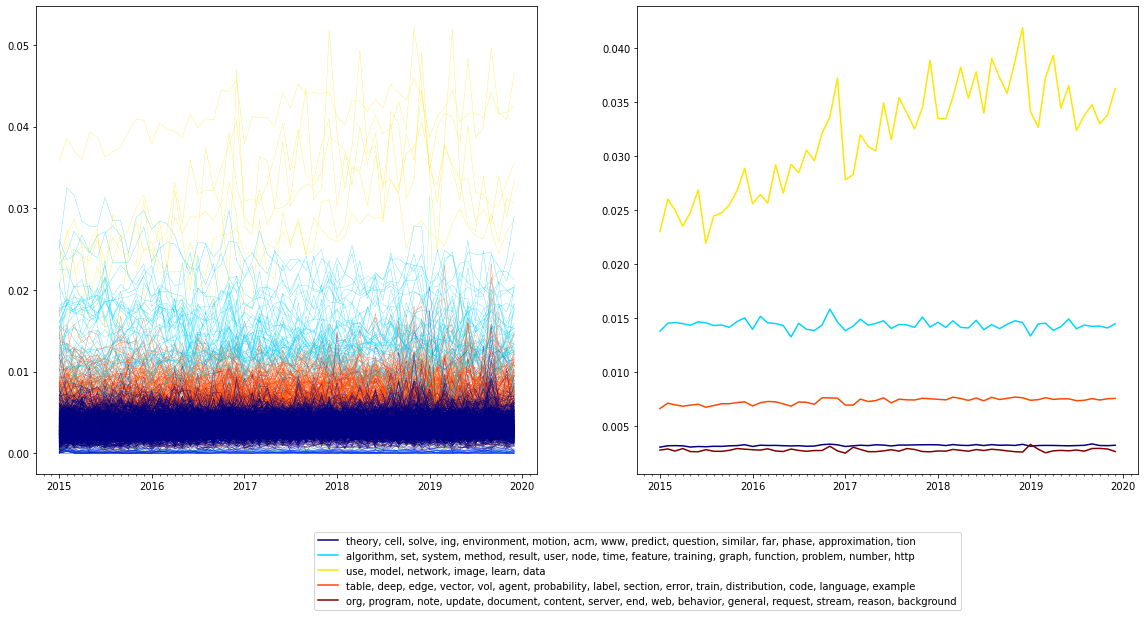

In [12]:
plt.figure(figsize=(17, 10))
ax = plt.subplot(121)
for row in vocabulary.itertuples(index=False):  # iterate through words
    plt.plot(
        tfidf_monthly_dataframe[row.word],
        color=colors.loc[row.cluster],
        linewidth=0.25,
    )

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax = plt.subplot(122)
for row in topics.itertuples(index=False):
    plt.plot(
        clusters_centers[row.word],
        color=colors.loc[row.cluster],
        label=row.word,
    )

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.legend(loc="lower center", bbox_to_anchor=(0, -0.3))
plt.subplots_adjust(0.05, 0.3, 0.95, 0.95)
plt.show()